# Evaluate and Compare Optimizers

Test classes and functions from `optprob` module for comparing different optimization algorithms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from dataclasses import dataclass
import skopt

from optprob.problems import (
    ConstrainedScalarOptimizationProblem, 
    solve_problem_with_optimizer, 
    solve_problem_with_optimizer_n_repeats
)
from optprob.plot_utils import convergence_plot, convergence_plot_n_repeats

import lpfgopt
lpfgopt.__version__

'1.0.1'

In [2]:
from platform import python_version
python_version()

'3.10.18'

## Optimization Problem Definition

### Example 1. Toy 1D Problem

In [3]:
class Toy1DProblem(ConstrainedScalarOptimizationProblem):

    def __init__(self):
        bounds = [(-5.0, 5.0)]
        name = "Toy1DProblem"
        super().__init__(bounds, name=name, global_minimum=[2.5085382557867626])

    @staticmethod
    def cost_function_to_minimize(x) -> float:
        return 1.0 / (-0.05 * x[0] ** 2 - np.cos(x[0]) + 0.25 * np.sin(3 * x[0] + 0.8) + 5)


# Test problem instance
problem = Toy1DProblem()
assert str(problem) == (
    "Toy1DProblem(_name='Toy1DProblem', _guesses=[], _input_dim=1, "
    "_bounds=[(-5.0, 5.0)], _global_minimum=[2.5085382557867626])"
)
assert problem.bounds == [(-5.,  5.)]
assert problem.input_dim == 1
assert problem.nfev == 0
assert problem.guesses == []
assert problem([0.5]) == 0.23275605031813504
assert problem.guesses == [(0.23275605031813504, [0.5])]
assert problem.nfev == 1
assert problem([-5]) == 0.3108649328945798
assert problem([5]) == 0.29041392127738885
assert problem.nfev == 3
assert problem.best_guess == (0.23275605031813504, [0.5])

# Find global minimum using Scipy and a good initial guess
sol = scipy.optimize.minimize(problem, x0=2.5, bounds=problem.bounds, tol=1e-15)
assert sol.status == 0
print(sol.fun, sol.x.item())
assert np.array_equal(problem.global_minimum, sol.x)

0.17499977934365754 2.5085382557867626


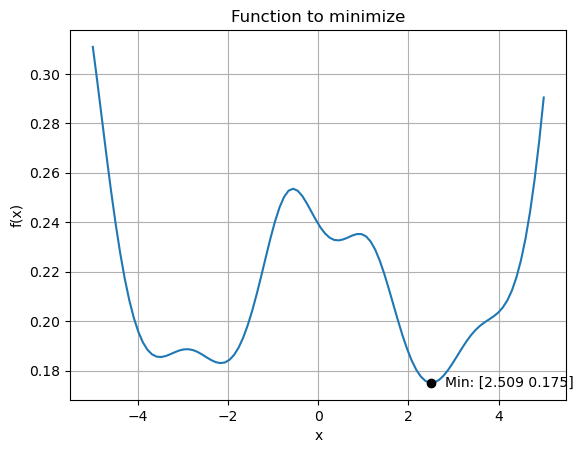

In [4]:
X = np.linspace(-5, 5, 100).reshape(1, -1)
Y = problem(X)

min_pt = np.array([problem.global_minimum[0], problem(problem.global_minimum)])

plt.plot(X.T, Y.T)
plt.plot(*min_pt, 'ko')
plt.annotate(f'Min: {min_pt.round(3)}', min_pt, xytext=(10, 0),
             textcoords='offset points', va='center')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function to minimize')
plt.grid()

In [5]:
rng = np.random.default_rng(0)
x0 = rng.uniform(*zip(*problem.bounds))
sol = solve_problem_with_optimizer(problem, scipy.optimize.minimize, x0, bounds=problem.bounds)
sol

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.17499977934672517
        x: [ 2.509e+00]
      nit: 5
      jac: [ 7.411e-07]
     nfev: 16
     njev: 8
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

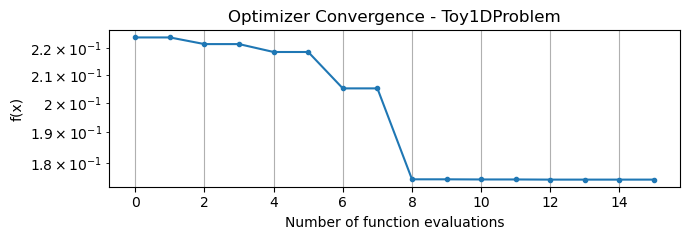

In [6]:
convergence_plot(problem)
plt.tight_layout()
plt.show()

In [7]:
solve_problem_with_optimizer(problem, lpfgopt.minimize, problem.bounds)

        best: [np.float64(0.1830081469735778), -2.158828776160661]
 final_error: np.float64(9.375200731615528e-06)
         fun: np.float64(0.1830081469735778)
       maxcv: 0
     message: 'Tolerance condition satisfied'
        nfev: 301
         nit: 281
    pointset: [[np.float64(0.1830081469736631), -2.1588271095954465], [np.float64(0.18300814697367276), -2.158830442921649], [np.float64(0.18300814697360027), -2.1588295650013], [np.float64(0.18300814697362666), -2.1588299596212677], [np.float64(0.1830081469735816), -2.1588283866132487], [np.float64(0.18300814697364978), -2.1588302219355247], [np.float64(0.18300814697358503), -2.1588292056819465], [np.float64(0.18300814697362186), -2.1588275654792533], [np.float64(0.18300814697360757), -2.1588277730658088], [np.float64(0.18300814697360532), -2.1588296538458263], [np.float64(0.18300814697368625), -2.158826902569804], [np.float64(0.18300814697363882), -2.158830103750949], [np.float64(0.18300814697358206), -2.158828365826614], [np.floa

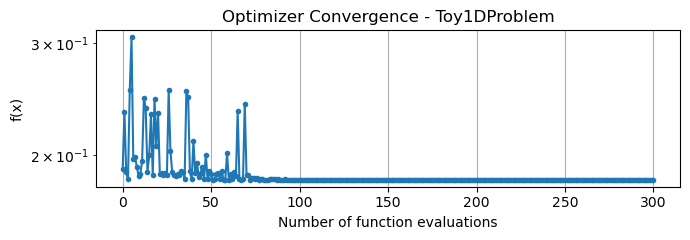

In [8]:
convergence_plot(problem)
plt.tight_layout()
plt.show()

In [9]:
fun_evals, unique_solutions = solve_problem_with_optimizer_n_repeats(problem, lpfgopt.minimize, 20, problem.bounds, tol=1e-6)
unique_solutions

Counter({(2.508538,): 17, (-2.158829,): 2, (-3.51245,): 1})

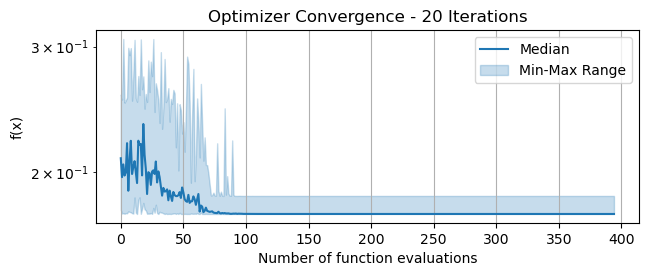

In [10]:
ax = convergence_plot_n_repeats(fun_evals)

## Bayesian Optimization

In [11]:
# Run Bayesian optimization
problem.reset()
res = skopt.gp_minimize(
    problem,            # the function to minimize
    problem.bounds,     # the bounds on each dimension of x
    n_calls=50,
    noise=1e-10,
    random_state=0
)
res

          fun: 0.17499984847992295
            x: [2.5072929577707797]
    func_vals: [ 2.353e-01  1.955e-01 ...  1.756e-01  1.754e-01]
      x_iters: [[0.9284461822501839], [3.442657485810175], [3.57945617622757], [3.472517387841256], [1.2356369678597243], [-1.1561829270730009], [-2.0246539345552765], [-4.432870226825568], [-2.2734370541988675], [-0.22334882678650025], [5.0], [2.5030594692913137], [-3.2221318696656196], [2.743344028134663], [-2.8069034687684584], [2.317653026177748], [2.557596688912204], [-5.0], [2.5189660786095116], [-3.7564665277672393], [4.292437907269585], [1.899371734104025], [-1.6517761649824632], [0.3222397301344948], [-3.5034307569808063], [3.029664927966447], [-4.061359949586361], [3.997995038411373], [-2.526741066995071], [2.5279331268239247], [2.5217513951707353], [2.604702868396748], [2.491545826479779], [2.4375392268522713], [2.560639771259643], [2.441180995888824], [2.4840975816507127], [2.4454324764558617], [2.48505723377297], [2.413420828004514], [2.43

In [12]:
res['x'], res['fun']

([2.5072929577707797], np.float64(0.17499984847992295))

In [13]:
problem.best_guess

(np.float64(0.17499984847992295), [2.5072929577707797])

In [14]:
fun_evals, unique_solutions = solve_problem_with_optimizer_n_repeats(
    problem, skopt.gp_minimize, 20, problem.bounds, noise=1e-10, n_calls=50
)
unique_solutions

Counter({(2.508196,): 1,
         (2.514269,): 1,
         (2.508176,): 1,
         (2.508062,): 1,
         (2.507719,): 1,
         (2.512295,): 1,
         (2.509314,): 1,
         (2.508903,): 1,
         (2.508679,): 1,
         (2.508528,): 1,
         (2.508208,): 1,
         (2.511944,): 1,
         (2.50692,): 1,
         (2.509707,): 1,
         (2.507724,): 1,
         (2.50596,): 1,
         (2.507297,): 1,
         (2.508391,): 1,
         (2.508583,): 1,
         (2.509283,): 1})

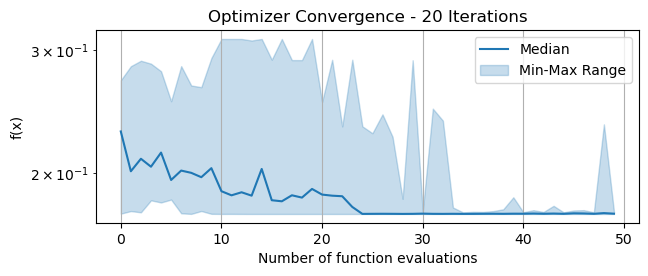

In [15]:
ax = convergence_plot_n_repeats(fun_evals)